In [8]:
# add path to ssa package
import sys
sys.path.append('../../..')

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pathlib
import cvxpy as cv

import pickle
from time import time

%matplotlib inline 

In [10]:
# tssa model
from src.ssa_methods.t_ssa import t_SSA

# plot with large fonts and other stuff
from src.plot.journal_style import EnableJournalStylePlotting

# data extraction methods
import src.data.electricity as electricity_data

# partition finding algorithms
from src.ssa_methods.ssa_complementary.ssa_multidim_partition import NextDichotomyPartition

## Data preprocessing

In [11]:
# names of observed signals
sig_names = ['Production program', 'Price']
# measure units
sig_units = ['MhW', 'TL']

num_signals = 2

In [12]:
# retrive signals and corresponding time grids
# they are already preproccessed
(train_data, time_grid_train), (test_data, time_grid_test) = electricity_data.GetTrainTestData(
    series_len=3000,
    test_ratio=0.18
)

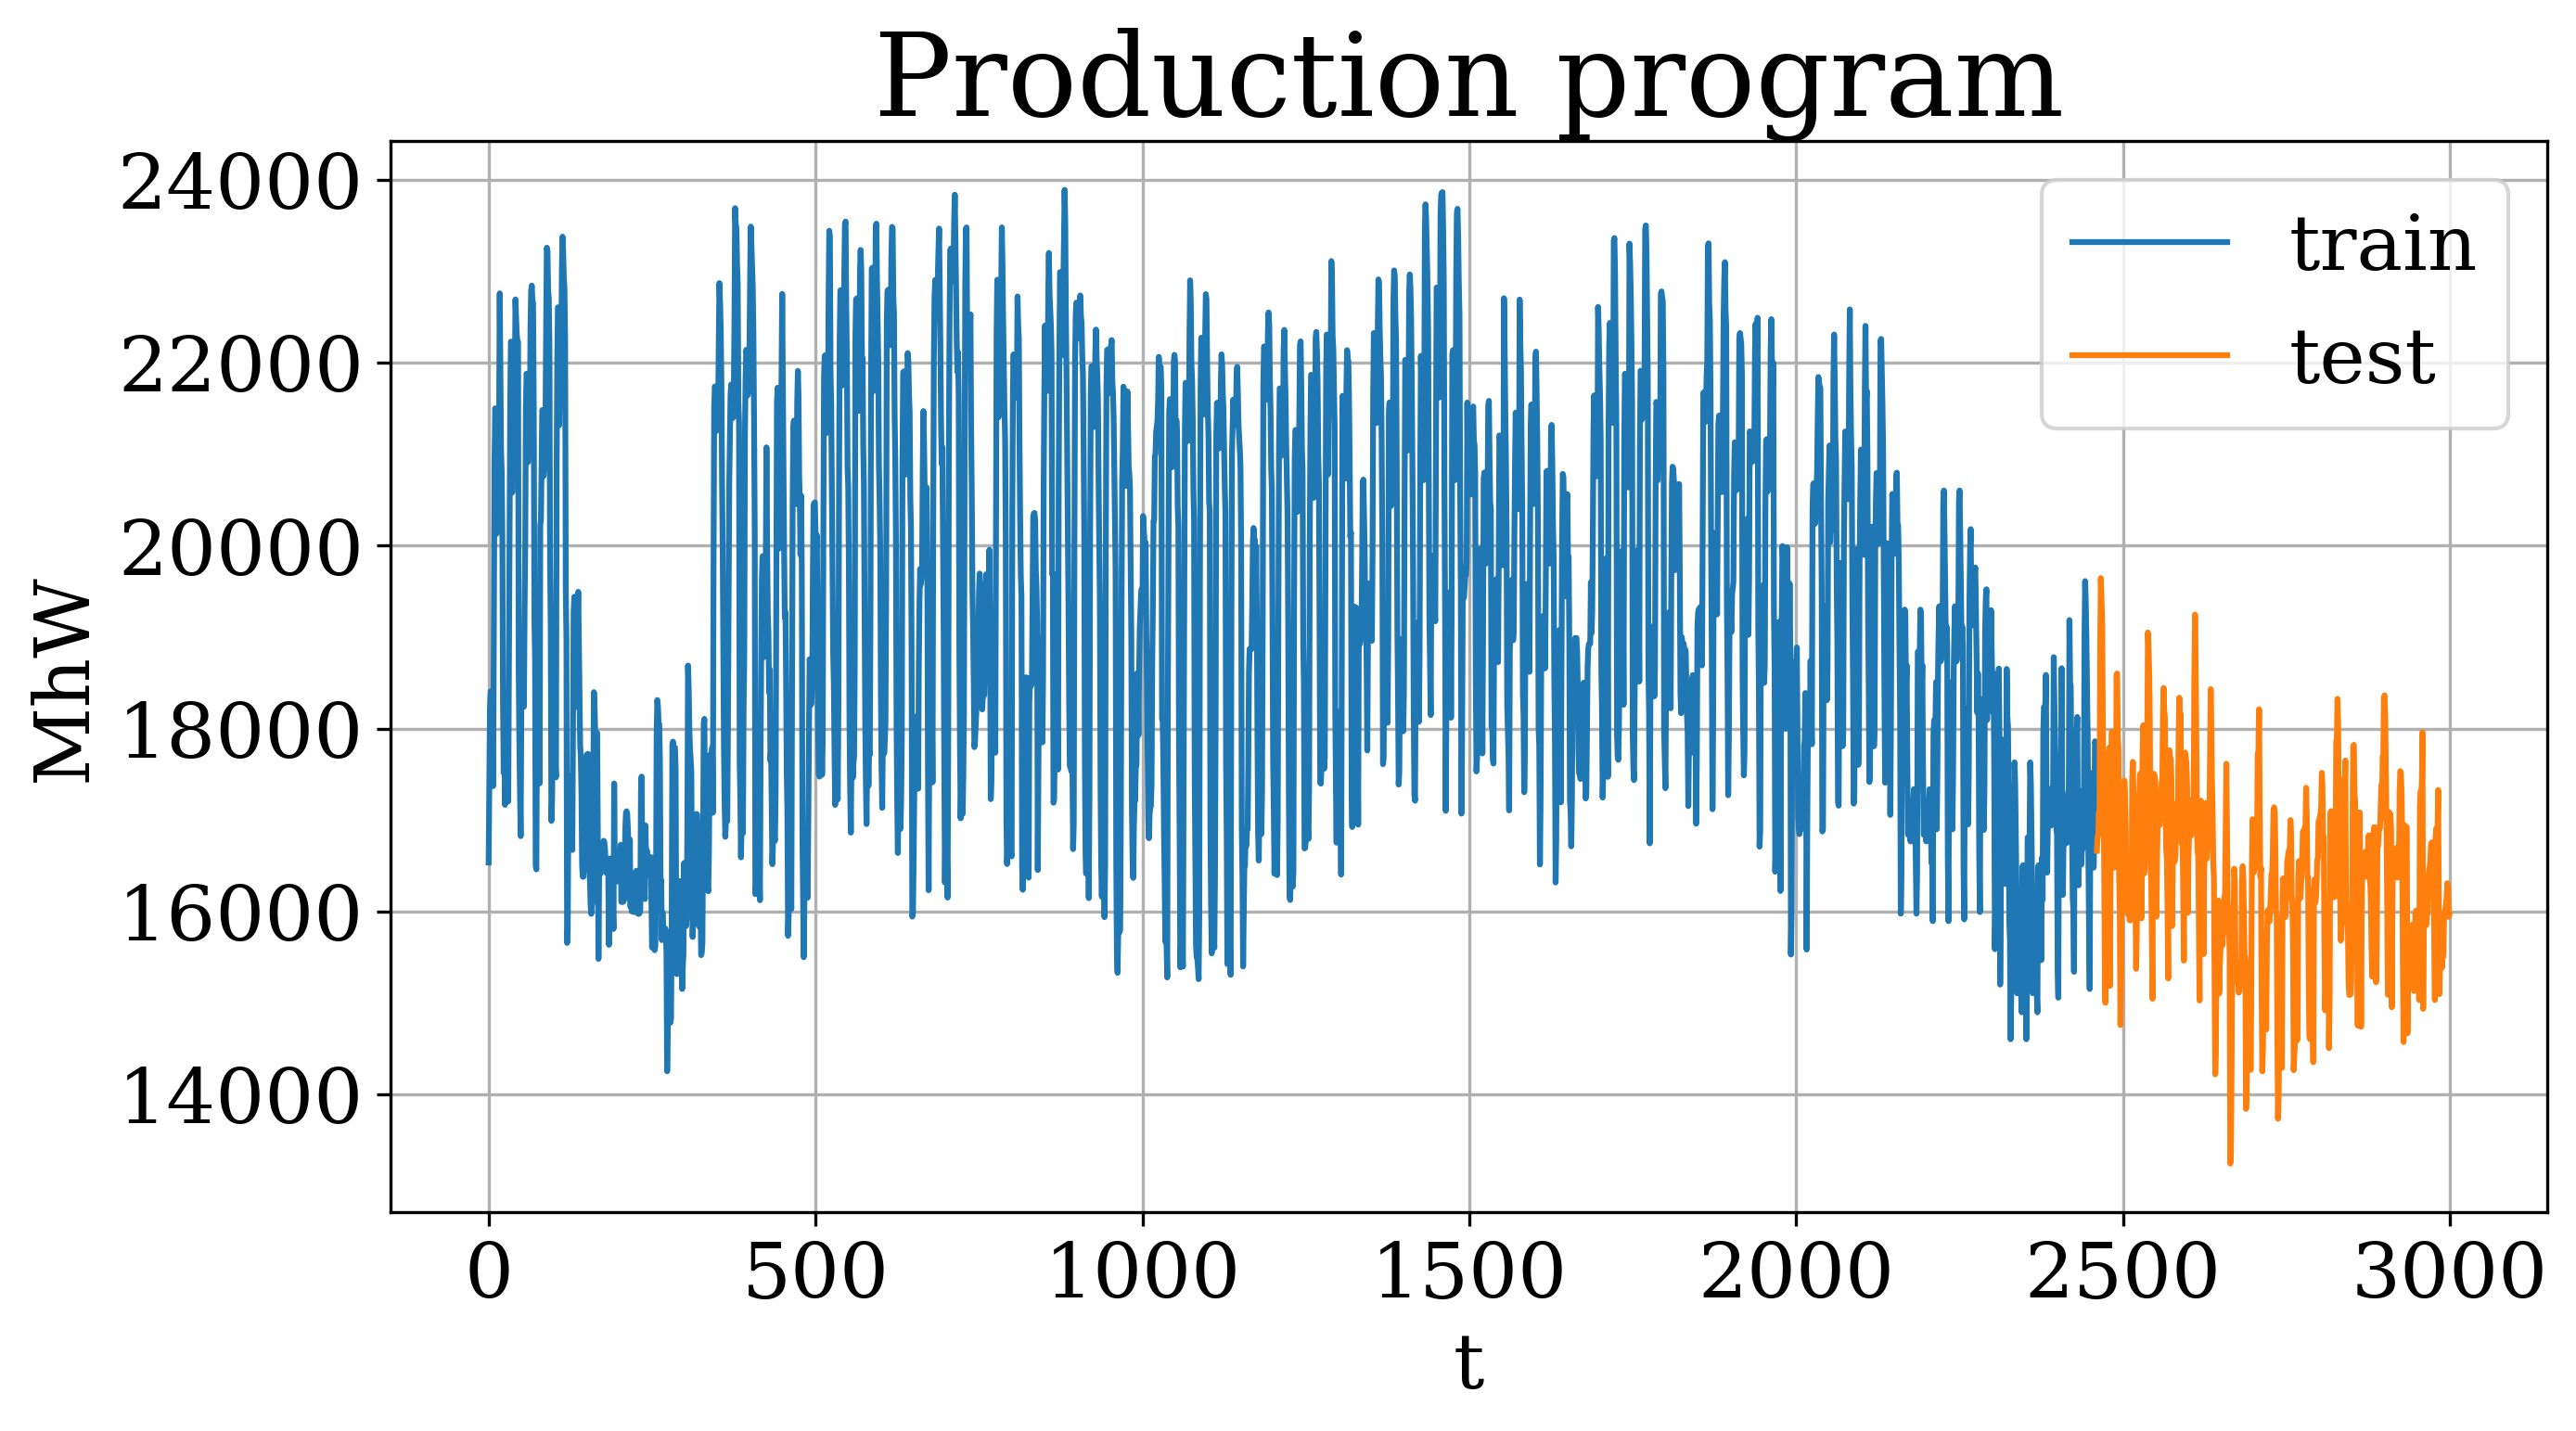

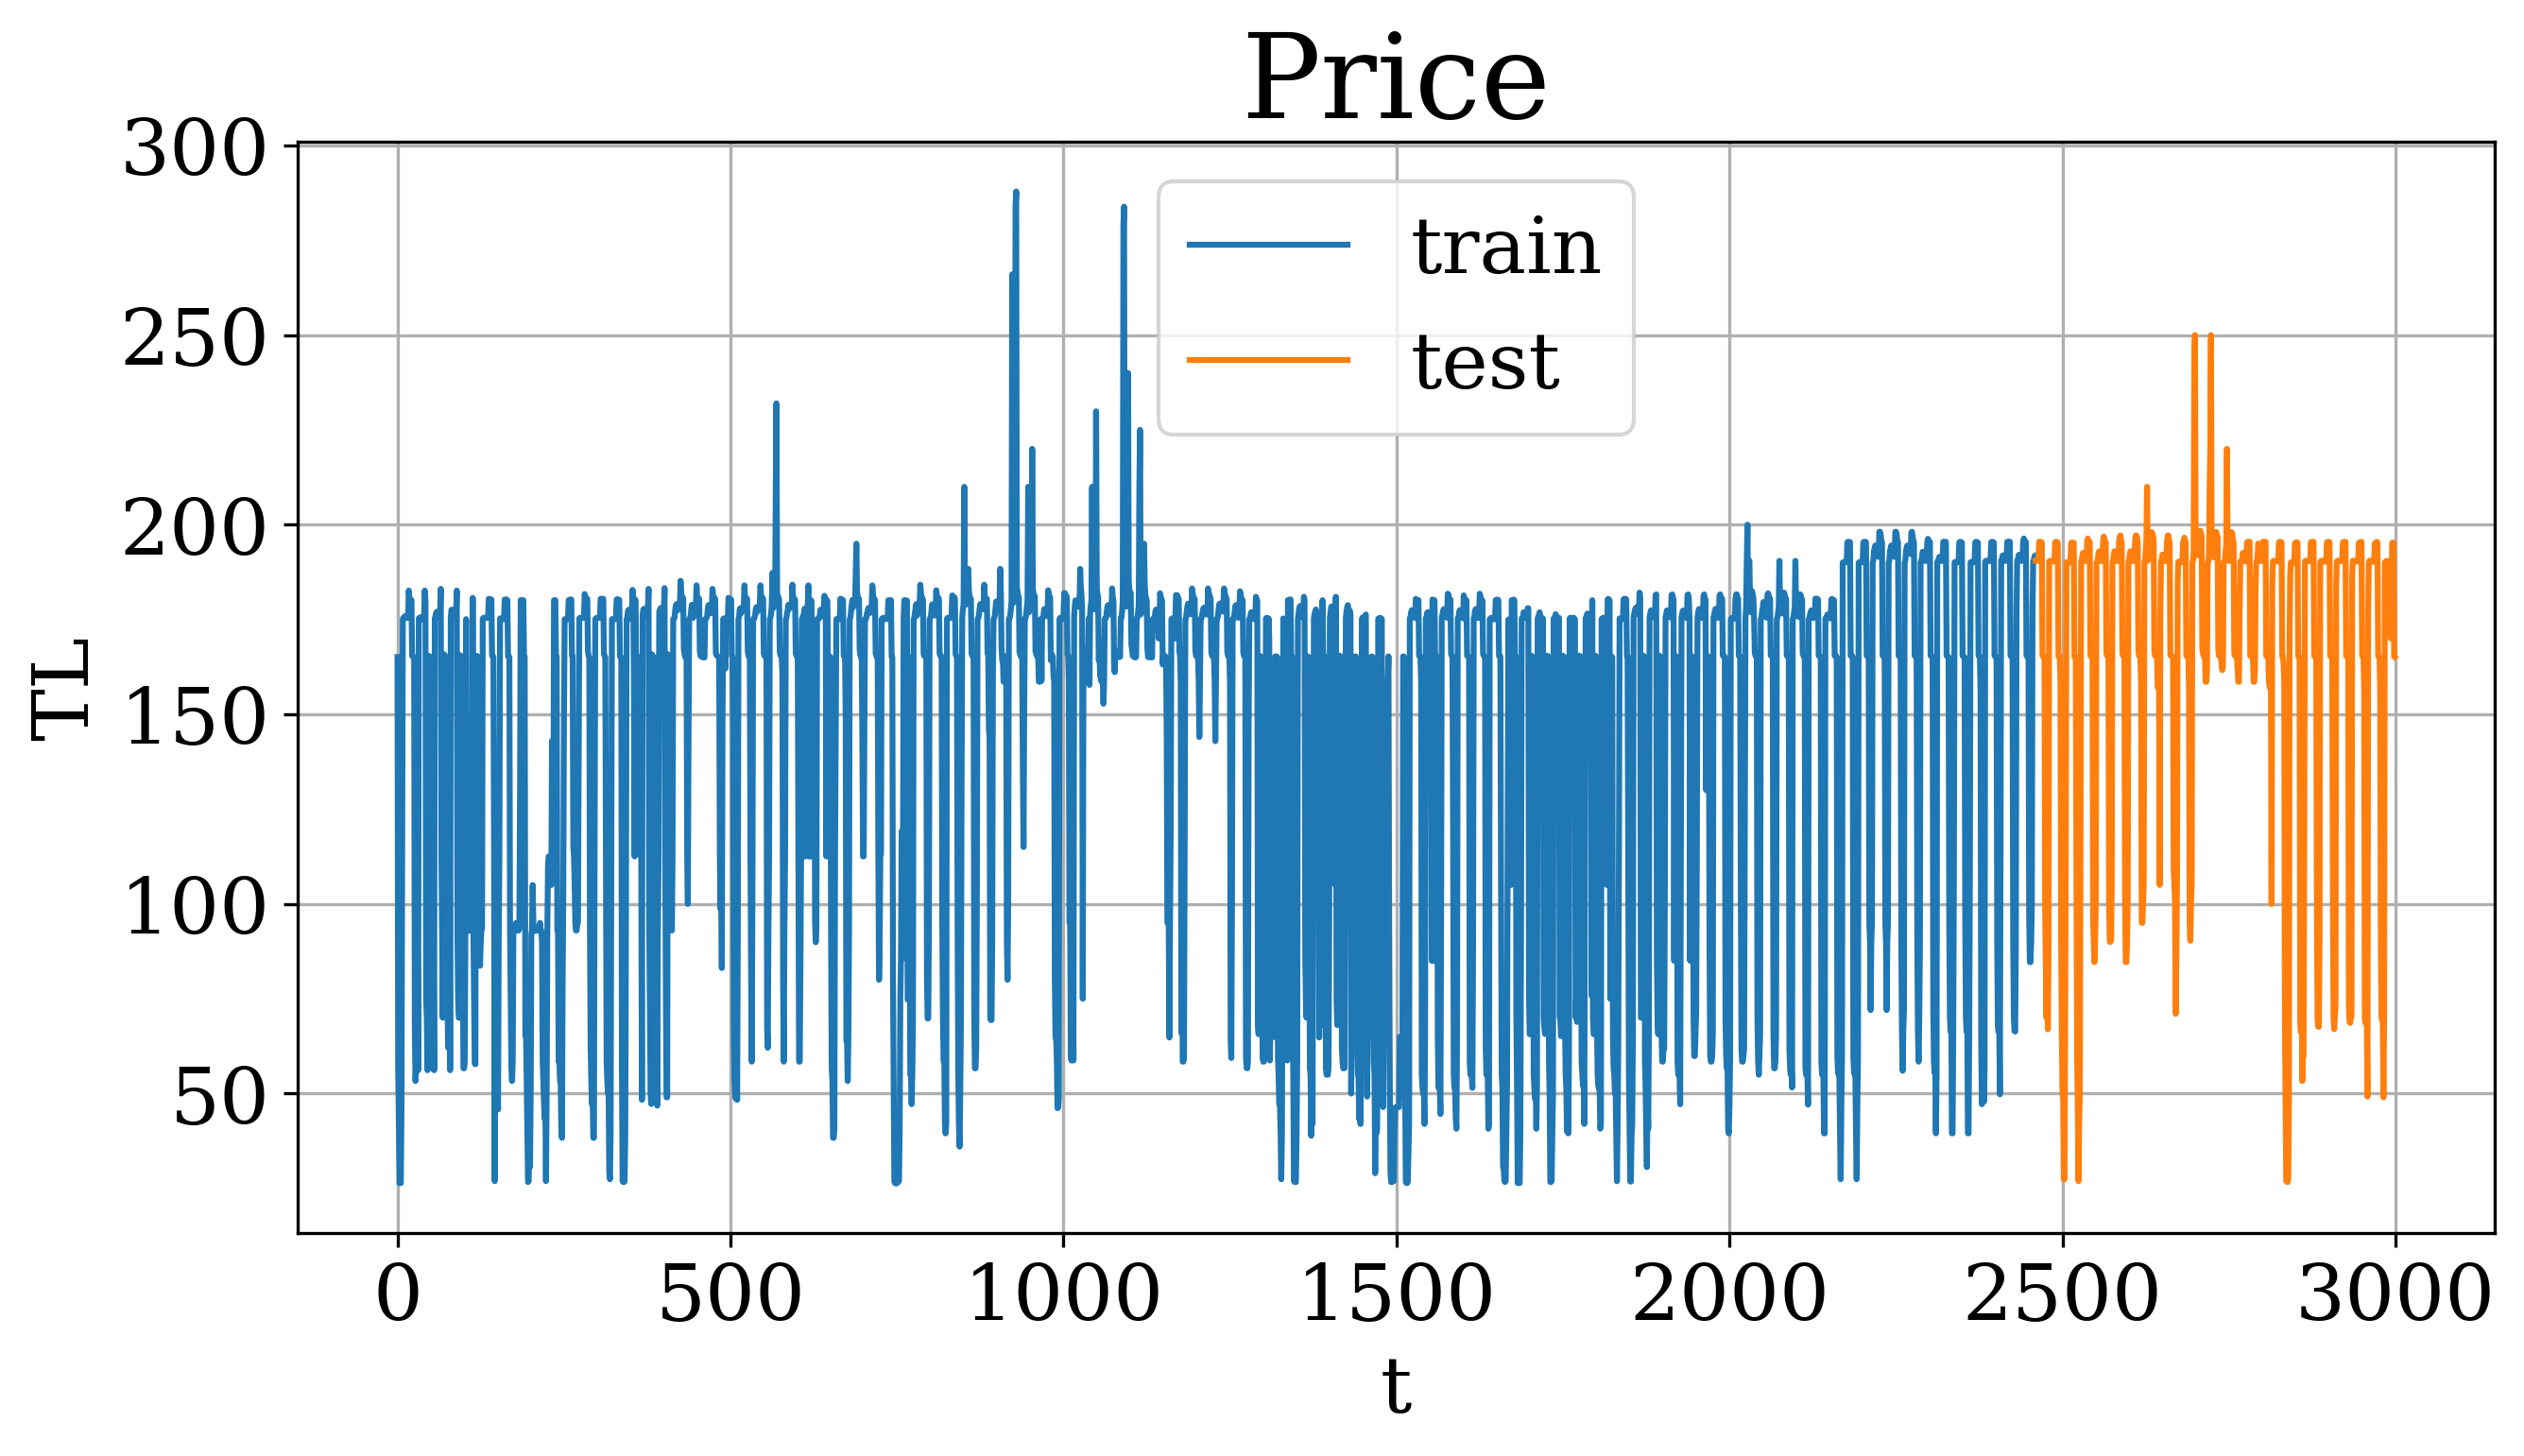

In [13]:
# draw signals
for i in range(num_signals):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(time_grid_train, train_data.T[i], label='train')
        ax.plot(time_grid_test, test_data.T[i], label='test')

        ax.grid(True)
        ax.legend()
        ax.set_xlabel('t')
        ax.set_ylabel(sig_units[i])
        ax.set_title(sig_names[i])

        if i == 0:
            fig.savefig("/home/cyrill/Sem8/Scientific_Work/figs/Electricity_Production.png", format='png')
        if i == 1:
            fig.savefig("/home/cyrill/Sem8/Scientific_Work/figs/Electricity_Price.png", format='png')

## Global method parameters

In [14]:
# aka L parameter
ssa_window_size = 500

cpd_ranks = np.arange(5, 50 + 1, 5)
# container for RHE metrics
RHE_results = {}

group_results = {}

# cut the size of the ILS system
max_col_size = 500

In [15]:
# colours for our signals (https://colorhunt.co/palette/7f27ff9f70fdfdbf60ff8911)
color_list = ['#7F27FF', '#FF8911', '#65B741']

In [ ]:
for cpd_rank in cpd_ranks:
    print(f"CPD-rank = {cpd_rank}")

    with open(f'./saved_model/cpd_rank_{cpd_rank}.pkl', 'rb') as f:
        t_ssa_obj: t_SSA = pickle.load(f)

    group_results[cpd_rank] = []

    num_signals = len(t_ssa_obj.t_s_list)
    for sig_num in range(num_signals):
        print(f"Signal {sig_num}")

        column_list = []

        weights, left_factors, right_factors = t_ssa_obj.get_available_factors(sig_num)

        # construct ILS system
        # get all factors except last
        for i in range(weights.shape[0] - 1):
            # compute residual matrix and cut its size
            factor_matrix = weights[i] * np.outer(left_factors[:, i], right_factors[i, :])
            hankelized_factor = factor_matrix.copy(); t_ssa_obj._hankelize_matrix(hankelized_factor)
            resid_matrix = factor_matrix - hankelized_factor

            column_list.append(
                resid_matrix.reshape(-1, 1)[:max_col_size]
            )

        ils_matrix = np.concatenate(column_list, axis=1)

        # CVXPY problem statement
        beta = cv.Variable(ils_matrix.shape[1], boolean=True)
        constraint = [cv.sum(beta) >= 2]
        obj = cv.Minimize(cv.norm(ils_matrix @ beta))
        problem = cv.Problem(obj, constraint)

        solve_time = time()
        problem.solve(solver="SCIP")
        solve_time = time() - solve_time

        print("solve time", solve_time)
        print("status:", problem.status)
        print("optimal value", problem.value)
        print("optimal beta", np.round(beta.value))

        # setting factors
        beta.value = np.round(beta.value).astype(np.int32)
        group_1 = np.argwhere(beta.value).flatten().tolist()
        group_2 = list(set(range(cpd_rank)) - set(group_1))

        group_results[cpd_rank].append([group_1, group_2])

        t_ssa_obj.set_factors_grouping([group_1, group_2], sig_num)

    # compute decomposition
    comp_sigs, hank_resid_abs, hank_resid_rel = t_ssa_obj.decompose_signals()

    RHE_results.update({
        cpd_rank: hank_resid_rel
    })

    # view and save relative hankerlization errors
    for i in range(train_data.shape[1]):
        print(f'RHE for {sig_names[i]}: {hank_resid_rel[i]}; Mean_ts_RHE = {np.mean(hank_resid_rel[i])}')
    print(f"Mean RHE for data = {np.mean(np.array(RHE_results[cpd_rank]))}")

    # plot results
    for i in range(train_data.shape[1]):
        with EnableJournalStylePlotting():
            fig, axs = plt.subplots(nrows=len(comp_sigs[i]), ncols=1, figsize=(15, 8))
    
            for j in range(len(comp_sigs[i])):
                axs[j].plot(time_grid_train, comp_sigs[i][j], label=f'Component {j + 1}', color=color_list[i])
    
                if j != len(comp_sigs[i]) - 1:
                    axs[j].tick_params(axis='x', labelsize=0)
    
                axs[j].grid(True)
                axs[j].legend()
    
            fig.supylabel(f'{sig_units[i]}', fontsize=20)
            fig.supxlabel('$t$', fontsize=20)
            fig.suptitle(f'{sig_names[i]}, rank = {cpd_rank}', fontsize=30)

    print("\n")

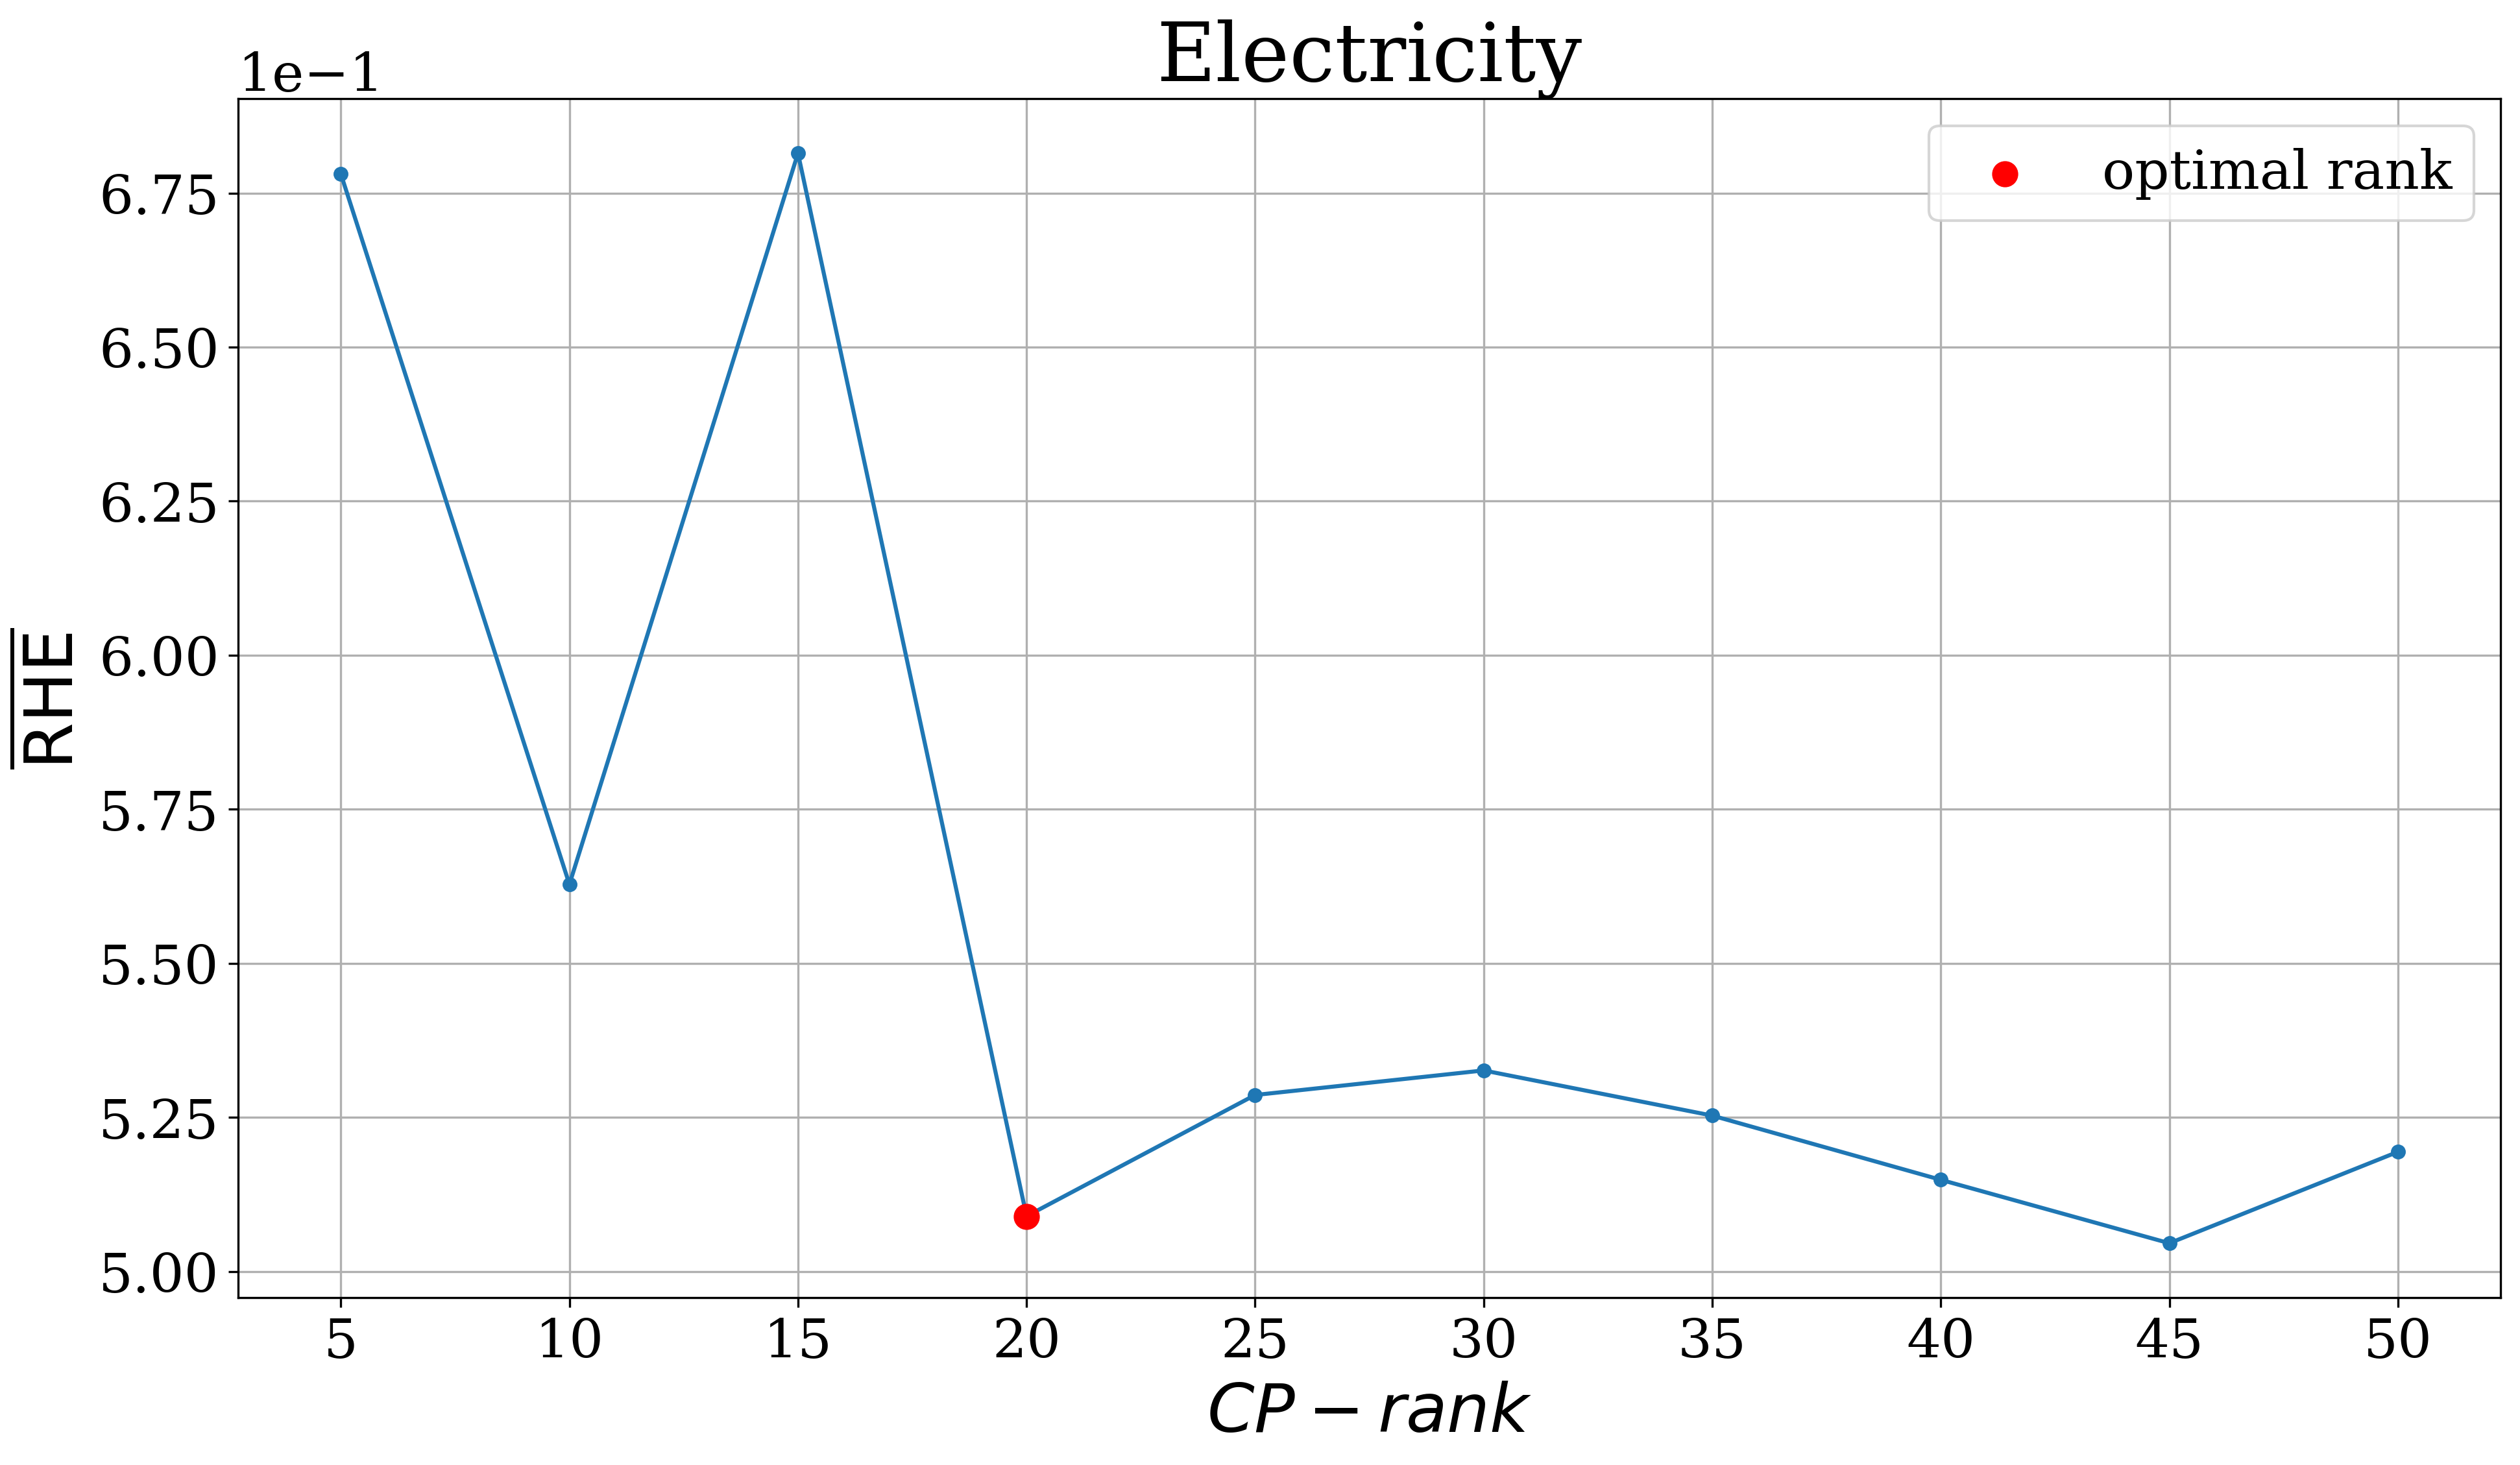

In [39]:
# plot mean RHE

rhe_means = []
for key, value in RHE_results.items():
    rhe_means.append(
        np.mean(np.array(value))
    )

with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(15, 8))

    ax.plot(cpd_ranks, rhe_means, marker=".")
    ax.scatter([20], [rhe_means[3]], marker=".", s=300, c="red", label="optimal rank", zorder=10)
    
    ax.legend()
    ax.grid(True)
    ax.set_ylabel(r"$ \overline{\text{RHE}} $", fontsize=25)
    ax.set_xlabel('$CP-rank$', fontsize=25)
    ax.set_title("Electricity")

    ax.set_xticks(cpd_ranks)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

    fig.savefig("./figs/decomposition/RHE_mean.png", format="png")

In [28]:
with open(f"./saved_model/group_results", "wb") as f:
    pickle.dump(group_results, f)

with open(f"./saved_model/rhe_results", "wb") as f:
    pickle.dump(RHE_results, f)

In [36]:
print(RHE_results[20])
print(list(map(np.mean, RHE_results[20])))

[array([0.04325505, 0.97064253]), array([0.05123714, 0.97064126])]
[0.5069487877915009, 0.5109391974355736]


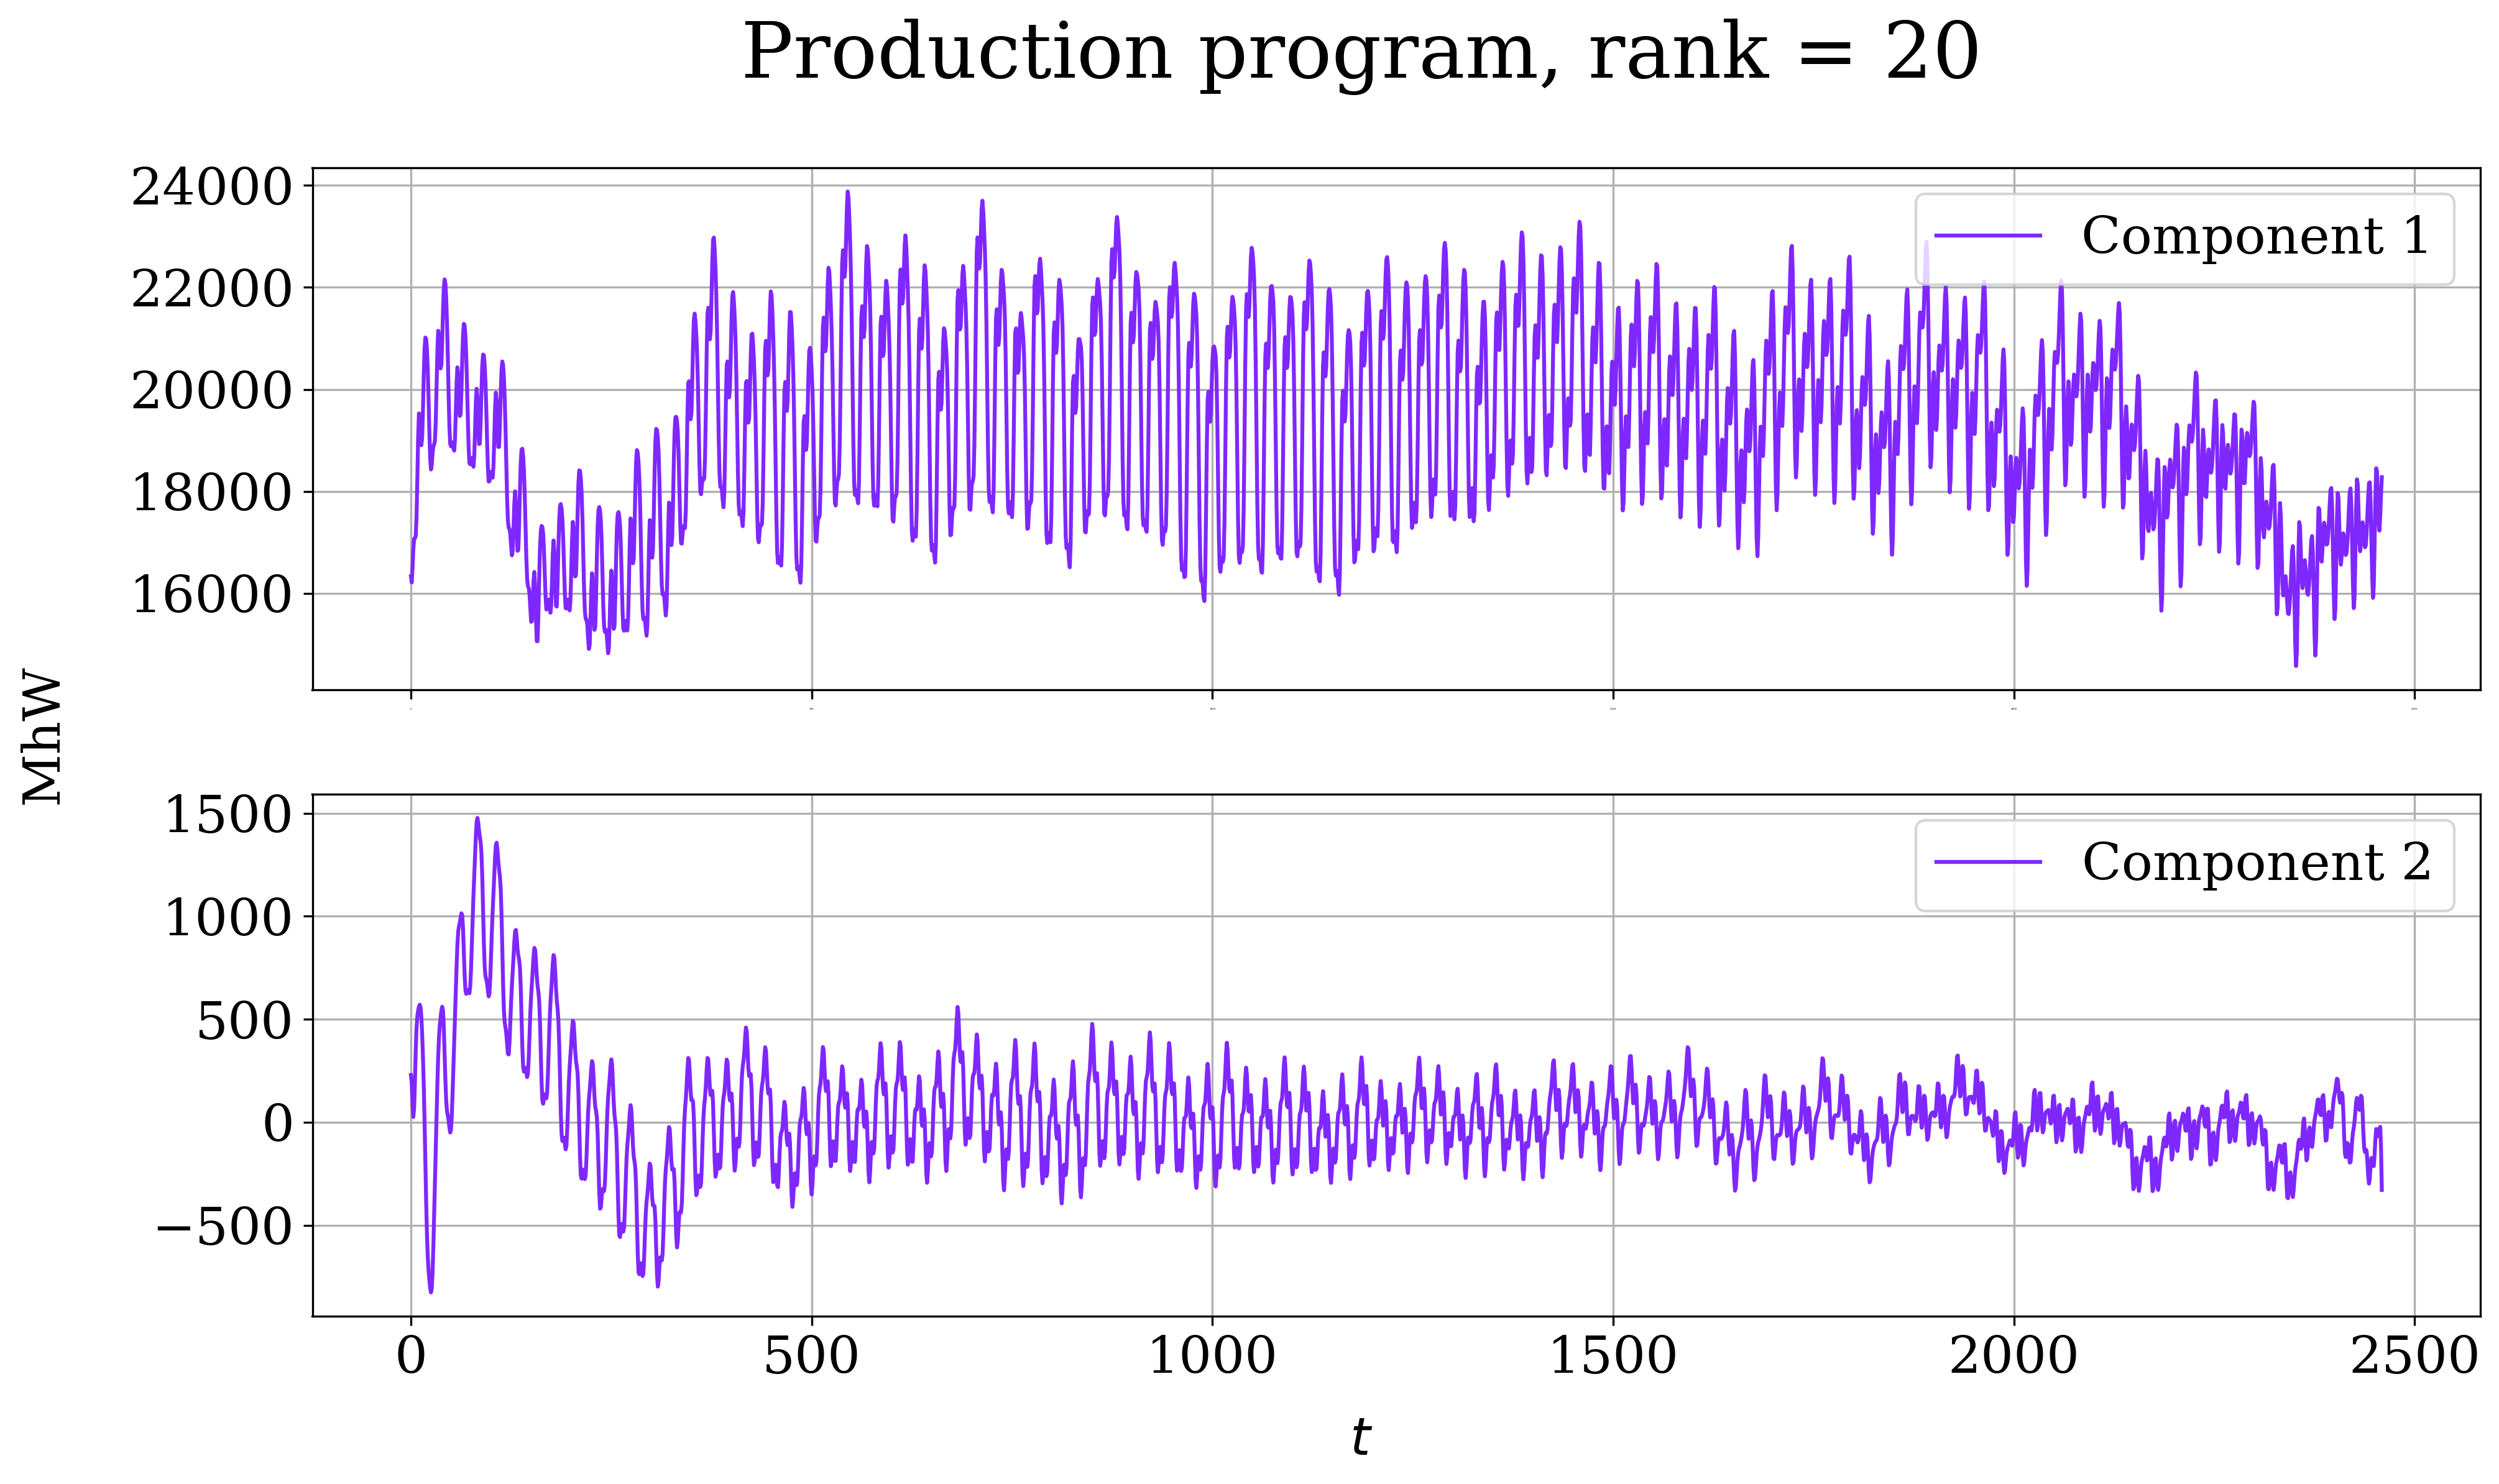

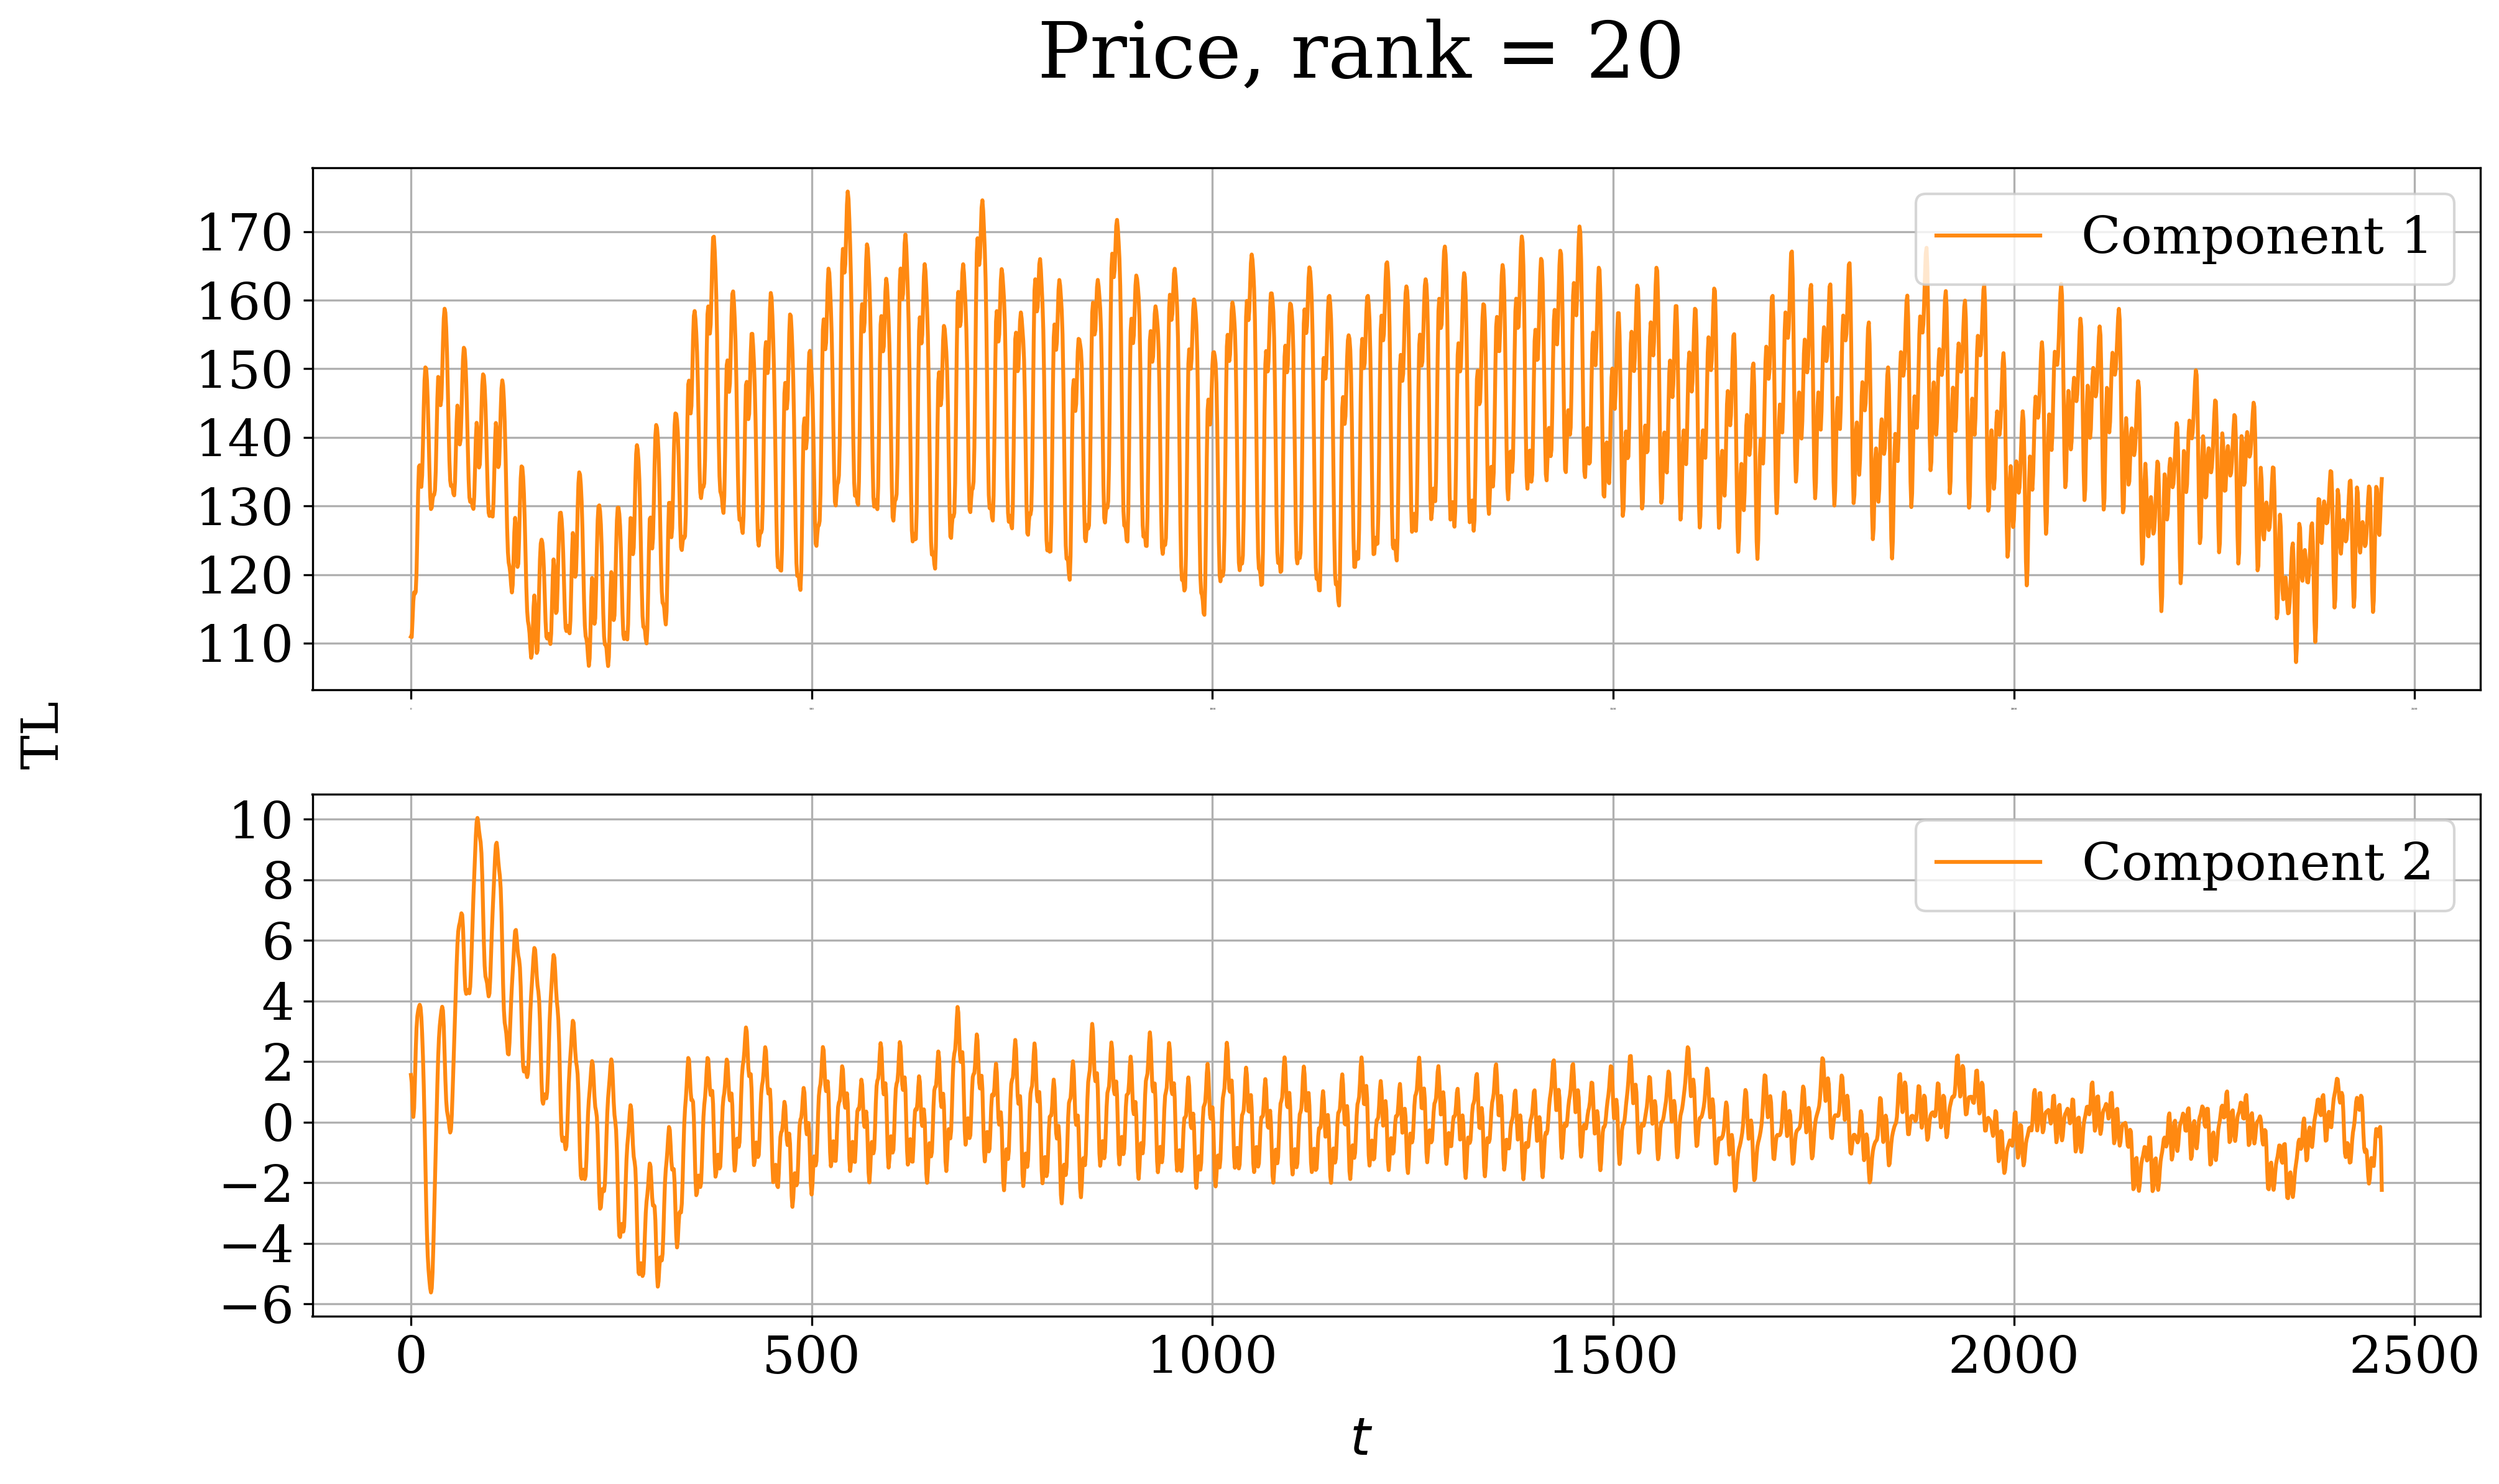

In [33]:
# restore results

with open(f'./saved_model/cpd_rank_20.pkl', 'rb') as f:
    t_ssa_obj: t_SSA = pickle.load(f)

num_signals = len(t_ssa_obj.t_s_list)
for sig_num in range(num_signals):
    t_ssa_obj.set_factors_grouping(group_results[20][sig_num], sig_num)

# compute decomposition
comp_sigs, hank_resid_abs, hank_resid_rel = t_ssa_obj.decompose_signals()

pathlib.Path("./figs/decomposition/cpd_rank_20/").mkdir(exist_ok=True)
# plot results
for i in range(train_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, axs = plt.subplots(nrows=len(comp_sigs[i]), ncols=1, figsize=(15, 8))

        for j in range(len(comp_sigs[i])):
            axs[j].plot(time_grid_train, comp_sigs[i][j], label=f'Component {j + 1}', color=color_list[i])

            if j != len(comp_sigs[i]) - 1:
                axs[j].tick_params(axis='x', labelsize=0)

            axs[j].grid(True)
            axs[j].legend()

        fig.supylabel(f'{sig_units[i]}', fontsize=20)
        fig.supxlabel('$t$', fontsize=20)
        fig.suptitle(f'{sig_names[i]}, rank = 20', fontsize=30)

        fig.savefig(f"./figs/decomposition/cpd_rank_20/{sig_names[i]}.png", format="png")